In [2]:
from datasets import load_dataset
from PIL import Image
import io
ds = load_dataset("jmhessel/newyorker_caption_contest", "explanation")
train_data = ds["train"]

/Users/donau/Desktop/LLM_humor/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(train_data.features)

{'image': Image(mode=None, decode=True, id=None), 'contest_number': Value(dtype='int32', id=None), 'image_location': Value(dtype='string', id=None), 'image_description': Value(dtype='string', id=None), 'image_uncanny_description': Value(dtype='string', id=None), 'entities': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'questions': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'caption_choices': Value(dtype='string', id=None), 'from_description': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None), 'n_tokens_label': Value(dtype='int32', id=None), 'instance_id': Value(dtype='string', id=None)}


In [4]:
def entity_extractor(entity_list: list):
    entities = []
    for entity in entity_list:
        entity_name = entity.split("/")[-1]
        entities.append(entity_name)
    return entities

In [ ]:
def get_by_contest_number(contest_number: int, train_data):
    subset = train_data.filter(lambda e : e["contest_number"] == contest_number)
    
    return subset

In [94]:
def get_image_by_contest_number(contest_number: int):
    l = get_by_contest_number(contest_number, train_data)["image"]
    if isinstance(l,list):
        l = l[0]
    return l

In [6]:
import base64
def image_to_bytes(img):
    buffered = io.BytesIO()
    img.save(buffered, format = "PNG")
    img_bytes = buffered.getvalue()
    img_b64 = base64.b64encode(img_bytes).decode("utf-8")
    return img_b64

In [7]:
def get_input(row):

    img = row["image"]
    desc = row["image_description"]
    number = row["contest_number"]
    #print(number)
    loc = row["image_location"]
    uncan = row["image_uncanny_description"]
    entities = entity_extractor(row["entities"])

    input_text = (
        f"Contest Number: {number} \n" + 
        "Description: " + desc + "\n" +
        "Location: " + loc + "\n" +
        "Uncanny description: " + uncan + "\n" +
        "Entities: " 
        + ", ".join(entities)
    )

    return input_text, img

def get_contest_id(row):
    return row["contest_number"]

In [8]:
train_data["image"][4].save("image_cache/image_4.jpg")
train_data["image"][1].save("image_cache/image_1.jpg")
print(train_data["image_description"][4])
print(train_data["contest_number"][4])
print(entity_extractor(train_data["entities"][4]))
print(train_data["image_location"][4])
print(train_data["image_uncanny_description"][4])
print(train_data["caption_choices"][4])




3 baseball players appear to be playing baseball in a living room.  A fourth person sits on a coach behind them, watching and talking on the phone
711
['Baseball', 'Telephone_call', 'Obliviousness']
the living room
It's unusual to see games of baseball being played inside houses
All his pitches have been inside.


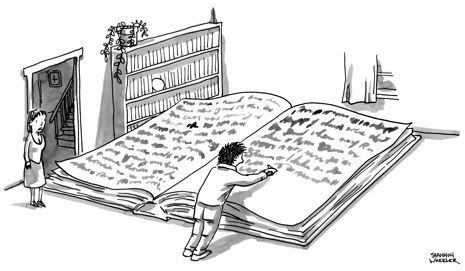

In [9]:
# img is your PIL image object
from IPython.display import display
display(train_data["image"][1])

In [10]:
from openai import OpenAI
from dotenv import load_dotenv
import os


model = "gpt-4o-mini"

instructions = (
    "Given the description, extracted entities, location, uncanny description, and the image provided below, "
    "identify key figures, characters, actions, location or the described situation in the cartoon. For each, generate:\n"
    "- 5 synonyms\n"
    "- 5 antonyms or contraries\n"
    "- 5 word groups that include the item (e.g., paper → paper cut)\n"
    "- 5 things that evoke a similar feeling or vibe (be creative)\n"
    "- 5 idioms (e.g., dog → raining cats and dogs)\n"
    "- 5 related mundane sentence or saying (baseball -> away game, inside pitch)"
    "- 5 widely recognizable references from general and or pop culture (e.g., rabbit → Aesop’s fables)\n\n"
    "Do not exaggerate the general culture references—keep them specific and broadly recognizable. Your goal is not to find the most niche reference."
    "Avoid overly generic entries.\n\n"

)

format_instruction = (
    "Return the result strictly as a JSON object. For each entity name and the central situation, use it as the object key. "
    "Include the contest number provided as the first key of the object"
    "Your response MUST include all the named entities, location, and the depicted action, event or situation in the cartoon."
    "Under each, include keys: synonyms, antonyms, word_groups, same_vibe, idioms, cultural_references. "
    "Example format for a cartoon in which a cat is drinking hot sauce in a kitchen:\n"
    "{\n"
    ' "contest_number": 321'
    '  "cat": {\n'
    '    "synonyms": [...],\n'
    '    "antonyms": [...],\n'
    '    "word_groups": [...],\n'
    '    "same_vibe": [...],\n'
    '    "idioms": [...],\n'
    '    "related_mundane_terms": [...],\n'
    '    "cultural_references": [...]\n'
    '  },\n'
    '  "hot sauce": {...}\n'
    '  "drinking hot sauce: {...}'
    '  "kitchen: {...} '
    "}"
)





def generate_lists(input_text, img, client) -> str:
    response = client.responses.create(
        model = model,
        input =[
            {
            "role" : "user",
            "content" : [
                {"type" : "input_text", "text" : instructions +  "\n" + format_instruction},
                {"type" : "input_text", "text" : input_text },
                {"type" : "input_image" , "image_url" : f"data:image/png;base64,{image_to_bytes(img)}" },
                
                ],
            }
        ],
    )
    #print(input_text)

    return response.output[0].content[0].text


In [126]:
import json
from pathlib import Path
from tqdm import tqdm
results = []

load_dotenv()
api_key=os.getenv("OPENAI_API_KEY")
#print(api_key)
client = OpenAI(api_key=api_key)

already_done = set()
# Take 20 samples from the filtered range
sample_rows = train_data.filter(lambda r: 530 <= r["contest_number"] <= 890).shuffle(seed=42).select(range(15))
for row in tqdm(sample_rows):
    contest_id = get_contest_id(row)
    if contest_id in already_done:
        continue
    (input_text, img) = get_input(row)
    already_done.add(contest_id)
    raw = generate_lists(input_text, img, client)
    cleaned = raw.strip("```json\n").rstrip("```")
    parsed = json.loads(cleaned)
    results.append(parsed)


Path("responses.json").write_text(json.dumps(results, indent=2))

100%|██████████| 15/15 [04:38<00:00, 18.54s/it]


76007

I will now try the ranking task. One that uses this list, one that does not and compare their performance

In [ ]:


ranking_dataset = load_dataset("yguooo/newyorker_caption_ranking", "1_rating")
ranking_dataset_train = ranking_dataset["train"]
print(ranking_dataset_train)

Generating train split: 1613585 examples [00:00, 2583033.70 examples/s]
Generating validation split: 270580 examples [00:00, 2390832.63 examples/s]
Generating test split: 298995 examples [00:00, 1556301.99 examples/s]


Dataset({
    features: ['contest_number', 'rank', 'caption', 'mean', 'precision', 'votes', 'not_funny', 'somewhat_funny', 'funny'],
    num_rows: 1613585
})


In [82]:

def load_cartoon(contest_number: int, img_dir: Path = IMG_DIR) -> Image.Image:
    try:
        return Image.open(img_dir / f"{contest_number}.jpg").convert("RGB")
    
    except:
        return get_image_by_contest_number(contest_number)

In [48]:
def build_index(data) -> dict[tuple[int, int], dict]:
    index = {}
    for row in data:
        index[(row["contest_number"], row["rank"])] = row
    return index


In [14]:
# For O(1) access to contest number rank pairs after building this index
index = build_index(ranking_dataset_train)

{'contest_number': 530, 'rank': 0, 'caption': 'Your overhead is going to kill you.', 'mean': 1.8241758242, 'precision': 0.0480665332, 'votes': 273, 'not_funny': 114, 'somewhat_funny': 93, 'funny': 66}
{'contest_number': 530, 'rank': 200, 'caption': 'Herewith a third and final notice from the cable company.', 'mean': 1.4591836735, 'precision': 0.0667359389, 'votes': 98, 'not_funny': 62, 'somewhat_funny': 27, 'funny': 9}


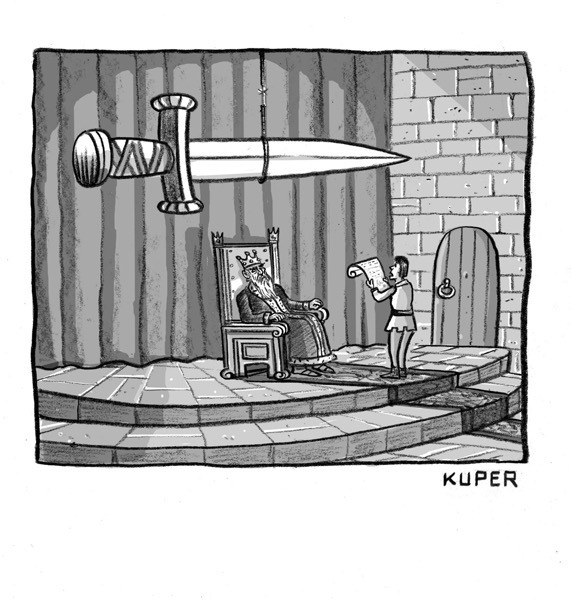

In [127]:
print(index[530, 0])
print(index[530, 200])
img_path = "cartoons" #change the source if you didnt use previous block that creates images.
image = load_cartoon(530, img_path)
display(image)


In [ ]:
import base64
import io
import json
import os
from pathlib import Path
from typing import Any

from datasets import Dataset, load_dataset
from openai import OpenAI
from PIL import Image

MODEL = "gpt-4o-mini"
RESPONSES_PATH = Path("responses.json")
IMG_DIR = Path(img_path)


def load_entity_terms(contest_number: int, path: Path = RESPONSES_PATH) -> dict[str, Any]:
    data: list[dict[str, Any]] = json.loads(path.read_text())
    for obj in data:
        if int(obj.get("contest_number")) == contest_number:
            return obj
    raise KeyError(contest_number)


def build_index(ds: Dataset) -> dict[tuple[int, int], dict[str, Any]]:
    idx: dict[tuple[int, int], dict[str, Any]] = {}
    for row in ds:
        idx[(row["contest_number"], row["rank"])] = row
    return idx


def load_caption(contest_number: int, rank: int, idx: dict[tuple[int, int], dict[str, Any]]) -> str:
    return idx[(contest_number, rank)]["caption"]



def image_to_base64(img: Image.Image) -> str:
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode()


# ── prompt builders ────────────────────────────────────────────────────────────
def compose_prompt_full(
        terms: dict[str, Any], winner: str, challenger: str
) -> list[dict[str, Any]]:
    payload = (
        "Given these related terms, pick the funnier caption and justify.Return the caption of the caption you chose not Candidate A or B.\n\n"
        f"Winner candidate: {winner}\n"
        f"Challenger candidate: {challenger}\n\n"
        f"Entity map:\n{json.dumps(terms, indent=2)}\n\n"
        'Return JSON: {"chosen": "...", "reason": "..."}'
    )
    return [{"type": "input_text", "text": payload}]


def compose_prompt_plain(winner: str, challenger: str) -> list[dict[str, Any]]:
    payload = (
        "Pick the funnier caption and justify. Return the caption of the caption you chose not Candidate A or B.\n\n"
        f"Candidate A: {winner}\n"
        f"Candidate B: {challenger}\n\n"
        'Return JSON: {"chosen": "...", "reason": "..."}'
    )
    return [{"type": "input_text", "text": payload}]


# ── model call helpers ─────────────────────────────────────────────────────────
def query_model(
        client: OpenAI, prompt: list[dict[str, Any]], img: Image.Image | None = None
) -> dict[str, Any]:
    content = prompt
    if img is not None:
        content += [
            {
                "type": "input_image",
                "image_url": f"data:image/png;base64,{image_to_base64(img)}",
            }
        ]
    resp = client.responses.create(model=MODEL, input=[{"role": "user", "content": content}])
    raw = resp.output[0].content[0].text.strip("```json\n").rstrip("```")
    return json.loads(raw)


# ── evaluation runners ─────────────────────────────────────────────────────────
def evaluate_with_terms(
        idx: dict[tuple[int, int], dict[str, Any]],
        compared_better: int,
        compared_worse: int,
        client: OpenAI,
        responses_path: Path = RESPONSES_PATH,
) -> list[dict[str, Any]]:
    responses: list[dict[str, Any]] = json.loads(responses_path.read_text())
    print(len(responses))
    out: list[dict[str, Any]] = []
    for obj in responses:
        try:
            num = int(obj["contest_number"])
        except KeyError:
            print(f"Could not find contest number for {obj}")
            continue
        try:
            winner = load_caption(num, compared_better, idx)
            challenger = load_caption(num, compared_worse, idx)
        except KeyError:
            print(f"Error loading the caption{obj}")
            continue
        img = load_cartoon(num)
        prompt = compose_prompt_full(obj, winner, challenger)
        res = query_model(client, prompt, img)
        out.append(
            {
                "contest number": num,
                "winner": winner,
                "challenger": challenger,
                "chosen_by_llm": res["chosen"],
                "correct": res["chosen"] == winner,
                "reason": res["reason"],
            }
        )
    return out


def evaluate_plain(
        idx: dict[tuple[int, int], dict[str, Any]],
        compared_better: int,
        compared_worse: int,
        client: OpenAI,
        responses_path: Path = RESPONSES_PATH,
) -> list[dict[str, Any]]:
    responses: list[dict[str, Any]] = json.loads(responses_path.read_text())
    out: list[dict[str, Any]] = []
    for obj in responses:
        try:
            num = int(obj["contest_number"])
            
        except KeyError:
            print(f"Could not find contest number for {obj}")
            continue
        try:
            winner = load_caption(num, compared_better, idx)
            challenger = load_caption(num, compared_worse, idx)
        except KeyError:
            print("Error loading the caption")
            continue
        prompt = compose_prompt_plain(winner, challenger)
        res = query_model(client, prompt, None)
        out.append(
            {
                "contest number": num,
                "winner": winner,
                "challenger": challenger,
                "chosen_by_llm": res["chosen"],
                "correct": res["chosen"] == winner,
                "reason": res["reason"],
            }
        )
    return out


# ── batch execution & persistence ──────────────────────────────────────────────
def run_and_save_all(
        idx: dict[tuple[int, int], dict[str, Any]],
        better_rank: int,
        worse_rank: int,
        client: OpenAI,
        out_full: Path,
        out_plain: Path,
) -> None:
    full_res = evaluate_with_terms(idx, better_rank, worse_rank, client)
    plain_res = evaluate_plain(idx, better_rank, worse_rank, client)
    out_full.write_text(json.dumps(full_res, indent=2))
    out_plain.write_text(json.dumps(plain_res, indent=2))


# ── accuracy utility ───────────────────────────────────────────────────────────
def accuracy(path: Path) -> float:
    data: list[dict[str, Any]] = json.loads(path.read_text())
    if not data:
        return -1.0
    return sum(1 for r in data if r["correct"]) / len(data)



In [128]:
run_and_save_all(index, 0, 25, client, Path("rankings_full.json"), Path("rankings_plain.json"))

15


Filter: 100%|██████████| 2340/2340 [00:01<00:00, 1206.71 examples/s]


In [123]:
responses: list[dict[str, Any]] = json.loads(Path("responses.json").read_text())
print(len(responses))

20


In [129]:
accuracy_full = accuracy(Path("rankings_full.json"))
accuracy_plain = accuracy(Path("rankings_plain.json"))
print(f"Accuracy Full: {accuracy_full} \n Accuracy Plain : {accuracy_plain}\n")

Accuracy Full: 0.6 
 Accuracy Plain : 0.6666666666666666



In [ ]:
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
trials  = 3
accuracy_full_accum = 0
accuracy_plain_accum = 0
for i in range(trials):
    run_and_save_all(index, 0, 25, client, Path("rankings_full.json"), Path("rankings_plain.json"))
    accuracy_full = accuracy(Path("rankings_full.json"))
    accuracy_plain = accuracy(Path("rankings_plain.json"))
    print(f"Accuracy in pass {i}\n Accuracy Full: {accuracy_full} \n Accuracy Plain : {accuracy_plain}\n")
    accuracy_full_accum += accuracy_full
    accuracy_plain_accum = accuracy_plain

print(f"Final Accumulated Results: Accuracy Full: {accuracy_full} \n Accuracy Plain : {accuracy_plain}\n")

Accuracy in pass 0
 Accuracy Full: 0.0 
 Accuracy Plain : 0.4

Accuracy in pass 1
 Accuracy Full: 0.4 
 Accuracy Plain : 0.2



KeyboardInterrupt: 